# CER Electricity Revised March 2012

## Import libaries

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", context="paper") # imporved plt styles

from tqdm.notebook import tqdm as tqdm

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

# Function definitions

In [6]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

# Load data

In [7]:
tikz_path='../doc/thesis/tikz/generated'

In [8]:
data_path=os.path.join("../data",'CER Electricity Revised March 2012', 'preprocessed', 'mini')

In [9]:
train_data=pd.read_csv(
    os.path.join(data_path,'train.csv'),
    parse_dates=['date_time'],
    infer_datetime_format=True,
    index_col=['date_time'],
    dtype={'id': 'uint16',
           'load': 'float32',
           'tempC': 'int8',
           'is_holiday': 'uint8'})
train_data.head()

,id,load,tempC,is_holiday
date_time,,,,
2009-07-14,1014,0.204,13,0
2009-07-14,1024,0.144,13,0
2009-07-14,1030,0.265,13,0
2009-07-14,1039,0.387,13,0
2009-07-14,1044,1.449,13,0


In [10]:
from thesis.data.splitter import TimeSeriesSplit

In [11]:
data_splitter = TimeSeriesSplit(
                1 - 0.1, TimeSeriesSplit.LEFT)

In [12]:
splitted_data = data_splitter(train_data)

In [13]:
splitted_data.describe().to_csv(data_path + '/stats.csv')

In [14]:
train_data.dtypes

id             uint16
load          float32
tempC            int8
is_holiday      uint8
dtype: object

In [15]:
train_data.index.min(),train_data.index.max()

(Timestamp('2009-07-14 00:00:00'), Timestamp('2010-10-30 23:30:00'))

In [16]:
mem_usage(train_data)

'179.47 MB'

# Resample Data and Scale Data

In [17]:
def scale_data(data, resample=False):
    if resample:
        data=data.groupby('id').resample('H').sum()
        data=data.droplevel('id')

    scalers = {
        'load': MinMaxScaler(feature_range=(0, 1)),
        'tempC': MinMaxScaler(feature_range=(-1, 1)),
        'is_holiday': MinMaxScaler(feature_range=(0, 1))
    }

    column_transformer = make_column_transformer(
        *[(scalers[k], [k]) for k in sorted(scalers.keys())],
        remainder='passthrough')

    scaled_data=column_transformer.fit_transform(data)

    train_data_scaled=pd.DataFrame(data=scaled_data,
                                   index=data.index,
                                   columns=list(sorted(scalers.keys())) + ['id'])
    train_data_scaled

    if resample:
        train_data_scaled['hour']=train_data_scaled.index.hour
    else:
        train_data_scaled['minute']=train_data_scaled.index.hour*2+train_data_scaled.index.minute//30
    train_data_scaled['weekday_name']=train_data_scaled.index.day_name()
    #selection['date_id']=selection.id.astype(str)+selection.index.date.astype(str)
    return train_data_scaled

In [18]:
resample=False

In [19]:
train_data_scaled = scale_data(train_data,resample=resample)
train_data_scaled.head()

,is_holiday,load,tempC,id,minute,weekday_name
date_time,,,,,,
2009-07-14,0.0,0.015861,0.368421,1014.0,0,Tuesday
2009-07-14,0.0,0.011173,0.368421,1024.0,0,Tuesday
2009-07-14,0.0,0.020627,0.368421,1030.0,0,Tuesday
2009-07-14,0.0,0.030159,0.368421,1039.0,0,Tuesday
2009-07-14,0.0,0.113134,0.368421,1044.0,0,Tuesday


In [20]:
train_data_scaled.dtypes

is_holiday      float64
load            float64
tempC           float64
id              float64
minute            int64
weekday_name     object
dtype: object

# Review data metrics

In [21]:
train_data_scaled.isnull().load.sum()

0

In [22]:
train_data_scaled.load[train_data_scaled.load < 0.0].any()

False

In [23]:
train_data_scaled.load.describe()

count    9.140064e+06
mean     4.025630e-02
std      5.385005e-02
min      0.000000e+00
25%      9.922650e-03
50%      2.062661e-02
75%      4.687866e-02
max      9.999999e-01
Name: load, dtype: float64

# Plot consumtion

## Select a subset of the data and prepare it for plotting

In [28]:
num_ids=len(train_data_scaled.id.unique())
num_ids

405

In [29]:
np.random.seed(1)
def sample_ts_form_n_ids(data, n):
    ids=np.random.choice(data.id.unique(),n, replace=False)
    return data[data.id.isin(ids)]

In [30]:
selection=sample_ts_form_n_ids(train_data_scaled, num_ids // 20)
selection

,is_holiday,load,tempC,id,minute,weekday_name
date_time,,,,,,
2009-07-14 00:00:00,0.0,0.018048,0.368421,1057.0,0,Tuesday
2009-07-14 00:00:00,0.0,0.011954,0.368421,1355.0,0,Tuesday
2009-07-14 00:00:00,0.0,0.011095,0.368421,1883.0,0,Tuesday
2009-07-14 00:00:00,0.0,0.027190,0.368421,2203.0,0,Tuesday
2009-07-14 00:00:00,0.0,0.027658,0.368421,2303.0,0,Tuesday
...,...,...,...,...,...,...
2010-10-30 23:30:00,1.0,0.039066,0.052632,6672.0,47,Saturday
2010-10-30 23:30:00,1.0,0.016251,0.052632,6787.0,47,Saturday
2010-10-30 23:30:00,1.0,0.037659,0.052632,6860.0,47,Saturday


In [26]:
len(selection.id.unique())

20

In [27]:
len(selection.index.weekday)/7

64532.57142857143

In [28]:
#mem_usage(selection)

## Consuption per weekday

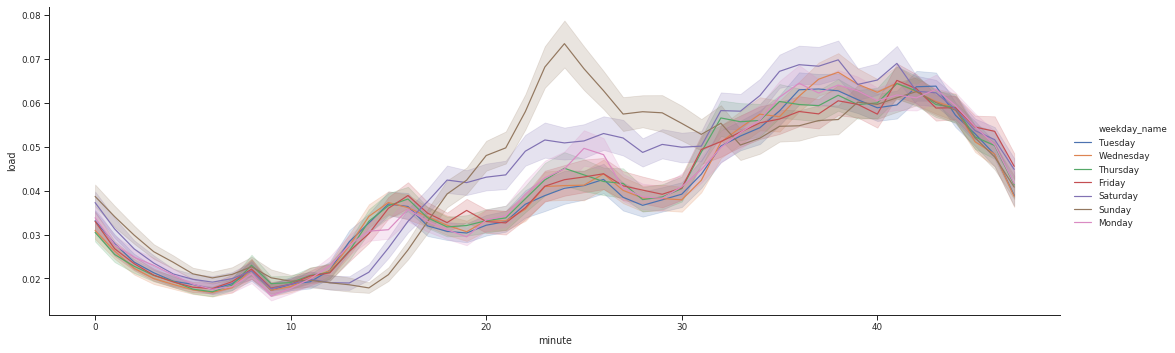

In [30]:
fig=sns.relplot(
    kind='line',
    x='hour' if resample else 'minute',
    y='load',
    hue='weekday_name',
    #estimator=None,
    #units='date_id',
    aspect=3,
    data=selection)
tikzplotlib.clean_figure()
file_path=os.path.join(tikz_path,'rel_plot_week.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

## Weekend vs. Weekday

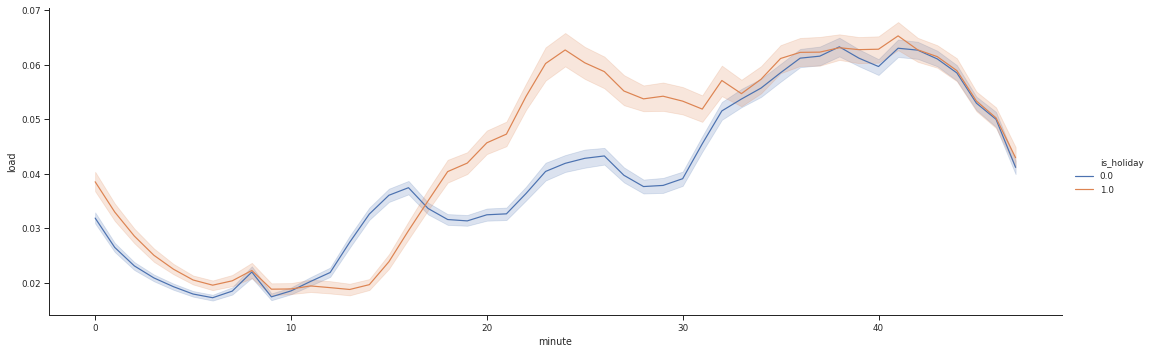

In [31]:
sns.relplot(
    x='hour' if resample else 'minute',
    y='load',
    kind='line',
    hue='is_holiday',
    aspect=3,
    data=selection)
tikzplotlib.clean_figure()
file_path=os.path.join(tikz_path,'rel_plot_holiday.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

## Individual Consumtion pattern

In [32]:
N=10
selection2=sample_ts_form_n_ids(selection,N)

In [38]:
selection2.id.unique()

array([2203., 2303., 2334., 3300., 4675., 5467., 5615., 6041., 6860.,
       6954.])

In [34]:
selection2['date_id'] = selection2.index.date.astype(str) + selection2.id.astype(str)

/home/marcel/miniconda3/envs/tfgpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


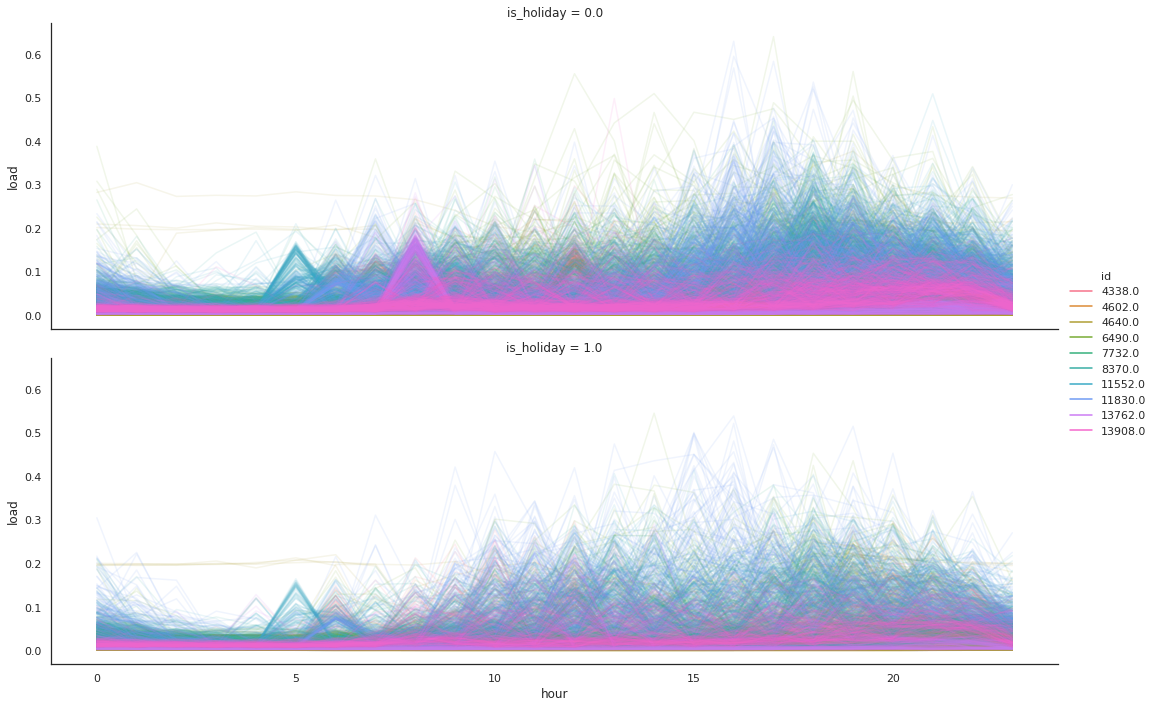

In [61]:
sns.relplot(
    kind='line',
    x='hour' if resample else 'minute',
    y='load',
    hue='id',
    row='is_holiday',
    #ci='sd',
    estimator=None,
    units='date_id',
    palette=sns.color_palette("husl", N),
    alpha=0.1,
    aspect=3,
    data=selection2)

# Can we find Clusters ?
Inspired by: https://towardsdatascience.com/clustering-electricity-profiles-with-k-means-42d6d0644d00

In [63]:
pt=pd.pivot_table(selection,
                  columns=selection['hour' if resample else 'minute'],
                  index=['id',selection.index.get_level_values('date_time').date],
                  values='load')
pt

hour                      0         1         2         3         4   \
id                                                                     
2088.0  2009-07-14  0.098945  0.068977  0.045930  0.042021  0.034814   
        2009-07-15  0.069832  0.045238  0.034977  0.040596  0.030091   
        2009-07-16  0.047355  0.062788  0.032819  0.049269  0.032697   
        2009-07-17  0.106030  0.050776  0.046256  0.046297  0.030702   
        2009-07-18  0.070728  0.068570  0.043121  0.123824  0.050409   
...                      ...       ...       ...       ...       ...   
14272.0 2010-10-26  0.033878  0.035466  0.038153  0.037216  0.027648   
        2010-10-27  0.094141  0.027770  0.028218  0.029073  0.029643   
        2010-10-28  0.044994  0.034203  0.035140  0.026793  0.028258   
        2010-10-29  0.127774  0.040881  0.028503  0.029399  0.030172   
        2010-10-30  0.036931  0.033023  0.032534  0.035303  0.037054   

hour                      5         6         7         8         9   ...  \
id                                                                    ...   
2088.0  2009-07-14  0.044505  0.032330  0.028706  0.066941  0.044505  ...   
        2009-07-15  0.044668  0.030132  0.043569  0.031801  0.113197  ...   
        2009-07-16  0.044831  0.033185  0.031842  0.043080  0.062014  ...   
        2009-07-17  0.042469  0.028544  0.044912  0.049839  0.062503  ...   
        2009-07-18  0.032086  0.042021  0.043324  0.035791  0.083676  ...   
...                      ...       ...       ...       ...       ...  ...   
14272.0 2010-10-26  0.027851  0.029195  0.028258  0.069750  0.106397  ...   
        2010-10-27  0.040596  0.030294  0.026426  0.065556  0.091413  ...   
        2010-10-28  0.029236  0.025978  0.032900  0.057535  0.058390  ...   
        2010-10-29  0.027322  0.034529  0.034936  0.027118  0.079360  ...   
        2010-10-30  0.042958  0.034773  0.028421  0.036199  0.058919  ...   

hour                      14        15        16        17        18  \
id                                                                     
2088.0  2009-07-14  0.075614  0.182662  0.220489  0.159901  0.108351   
        2009-07-15  0.061851  0.042469  0.079645  0.103099  0.087829   
        2009-07-16  0.092960  0.071827  0.106153  0.141211  0.123865   
        2009-07-17  0.211165  0.125616  0.142840  0.207704  0.116414   
        2009-07-18  0.288937  0.167637  0.133922  0.207012  0.170121   
...                      ...       ...       ...       ...       ...   
14272.0 2010-10-26  0.052242  0.068570  0.098335  0.092308  0.100818   
        2010-10-27  0.050939  0.029399  0.048333  0.081762  0.109980   
        2010-10-28  0.039904  0.039782  0.062503  0.060507  0.105175   
        2010-10-29  0.061200  0.113197  0.086241  0.063887  0.089906   
        2010-10-30  0.045523  0.076673  0.032737  0.031882  0.100615   

hour                      19        20        21        22        23  
id                                                                    
2088.0  2009-07-14  0.149273  0.104483  0.089499  0.082577  0.098457  
        2009-07-15  0.102447  0.084816  0.087056  0.080704  0.123865  
        2009-07-16  0.160349  0.100981  0.106030  0.112749  0.145038  
        2009-07-17  0.135755  0.170976  0.212468  0.129525  0.123132  
        2009-07-18  0.182377  0.097317  0.091698  0.161204  0.095769  
...                      ...       ...       ...       ...       ...  
14272.0 2010-10-26  0.137058  0.110428  0.122073  0.111079  0.109980  
        2010-10-27  0.126104  0.155299  0.126715  0.104565  0.094426  
        2010-10-28  0.121870  0.130339  0.125942  0.105420  0.131642  
        2010-10-29  0.140600  0.109084  0.104198  0.108188  0.112749  
        2010-10-30  0.132212  0.128385  0.074718  0.073496  0.062747  

[9412 rows x 24 columns]

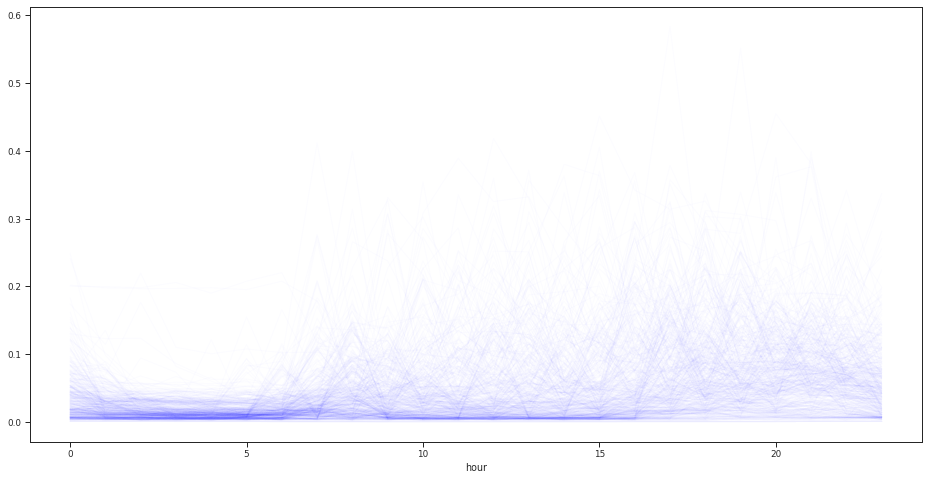

In [64]:
pt.sample(frac=0.05).T.plot(legend=False,
          color='blue',
          alpha=0.01,
          figsize=(16,8))

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

sillhoute_scores = []
n_cluster_list = np.arange(2,8).astype(int)

X = pt.to_numpy()

for n_cluster in tqdm(n_cluster_list):
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))

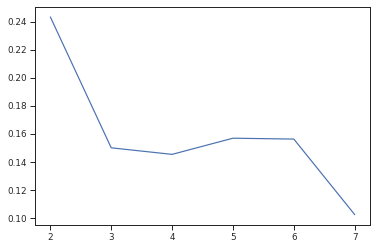

In [45]:
sns.lineplot(x=n_cluster_list,y=sillhoute_scores)

In [46]:
kmeans = KMeans(n_clusters=2)
cluster_found = kmeans.fit_predict(X)
cluster_found_sr = pd.Series(cluster_found, name='cluster')
cluster_found_sr

0       0
1       0
2       0
3       0
4       0
       ..
9407    0
9408    0
9409    0
9410    0
9411    1
Name: cluster, Length: 9412, dtype: int32

In [47]:
clusered=pt.set_index(cluster_found_sr,append=True)
clusered.xs(1, level='cluster', axis=0,drop_level=False)

date_time                         0         1         2         3         4   \
id                 cluster                                                     
2088.0  2009-09-12 1        0.074962  0.061729  0.072926  0.032860  0.034773   
        2009-10-03 1        0.050613  0.049228  0.061932  0.047925  0.045319   
        2009-10-10 1        0.099515  0.066289  0.031190  0.035914  0.014048   
        2009-10-11 1        0.023291  0.037135  0.019219  0.024472  0.023006   
        2009-10-12 1        0.021947  0.021744  0.034448  0.021092  0.023250   
...                              ...       ...       ...       ...       ...   
14272.0 2010-10-16 1        0.044261  0.041614  0.043121  0.050409  0.047274   
        2010-10-18 1        0.053382  0.050409  0.043202  0.045319  0.044790   
        2010-10-20 1        0.041696  0.039537  0.036361  0.034203  0.031801   
        2010-10-21 1        0.046826  0.046012  0.045971  0.049595  0.044749   
        2010-10-30 1        0.036931  0.033023  0.032534  0.035303  0.037054   

date_time                         5         6         7         8         9   \
id                 cluster                                                     
2088.0  2009-09-12 1        0.044179  0.034936  0.046093  0.030661  0.037298   
        2009-10-03 1        0.036361  0.040555  0.043487  0.037094  0.032615   
        2009-10-10 1        0.034203  0.035140  0.034733  0.035140  0.021581   
        2009-10-11 1        0.024350  0.032941  0.029195  0.029480  0.037949   
        2009-10-12 1        0.022232  0.030783  0.028869  0.031394  0.038153   
...                              ...       ...       ...       ...       ...   
14272.0 2010-10-16 1        0.044546  0.043080  0.043406  0.044261  0.057983   
        2010-10-18 1        0.053015  0.050409  0.042795  0.044749  0.061362   
        2010-10-20 1        0.030498  0.043039  0.063276  0.142799  0.057453   
        2010-10-21 1        0.048740  0.047803  0.046215  0.048495  0.051183   
        2010-10-30 1        0.042958  0.034773  0.028421  0.036199  0.058919   

date_time                   ...        14        15        16        17  \
id                 cluster  ...                                           
2088.0  2009-09-12 1        ...  0.035181  0.037502  0.048740  0.035303   
        2009-10-03 1        ...  0.017142  0.014007  0.050898  0.034570   
        2009-10-10 1        ...  0.026833  0.023535  0.037909  0.022354   
        2009-10-11 1        ...  0.035669  0.023454  0.026223  0.021866   
        2009-10-12 1        ...  0.025897  0.021173  0.025693  0.032330   
...                         ...       ...       ...       ...       ...   
14272.0 2010-10-16 1        ...  0.025490  0.033674  0.036809  0.036076   
        2010-10-18 1        ...  0.030335  0.030213  0.028625  0.027159   
        2010-10-20 1        ...  0.030132  0.033755  0.027159  0.041858   
        2010-10-21 1        ...  0.025815  0.096991  0.056680  0.051305   
        2010-10-30 1        ...  0.045523  0.076673  0.032737  0.031882   

date_time                         18        19        20        21        22  \
id                 cluster                                                     
2088.0  2009-09-12 1        0.107781  0.104931  0.070646  0.083961  0.077324   
        2009-10-03 1        0.066289  0.040596  0.071664  0.091575  0.073008   
        2009-10-10 1        0.026182  0.023739  0.041370  0.035425  0.025408   
        2009-10-11 1        0.037379  0.024594  0.024309  0.039497  0.032615   
        2009-10-12 1        0.023006  0.024146  0.037827  0.039985  0.026752   
...                              ...       ...       ...       ...       ...   
14272.0 2010-10-16 1        0.106682  0.083920  0.066004  0.062991  0.058838   
        2010-10-18 1        0.026345  0.073171  0.088440  0.081355  0.076184   
        2010-10-20 1        0.056436  0.071908  0.082414  0.062706  0.059449   
        2010-10-21 1        0.048577  0.055865  0.053626  0.05

In [48]:
sampled=clusered.sample(frac=0.05)

<Figure size 2304x720 with 0 Axes>

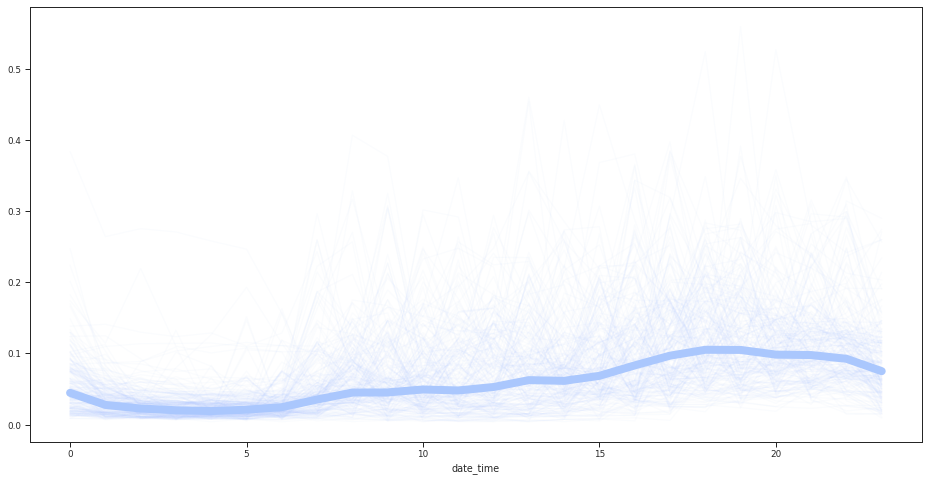

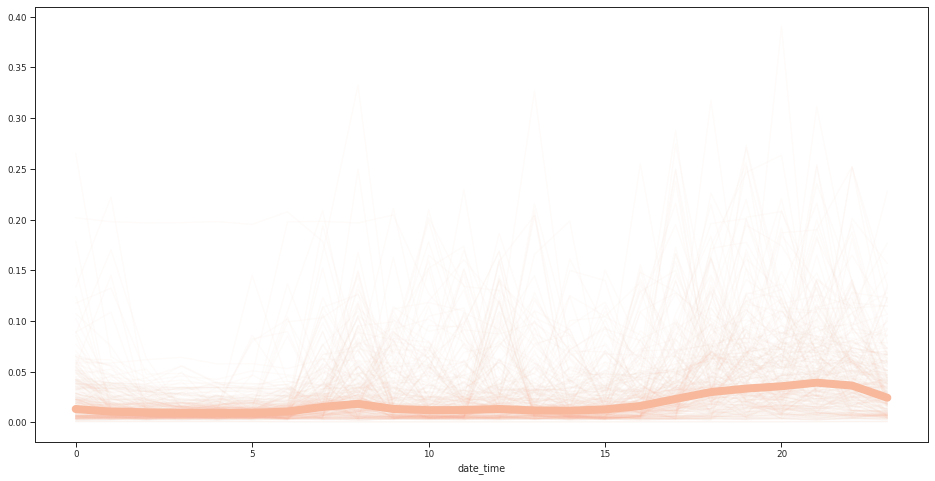

In [49]:
fig = plt.figure(figsize=(32,10))
color_list = sns.color_palette("coolwarm", kmeans.n_clusters).as_hex()
cluster_values = sorted(clusered.index.get_level_values('cluster').unique())

for cluster, color in tqdm(zip(cluster_values, color_list)):
    tmp=clusered.xs(cluster, level='cluster', axis=0)
    tmp.sample(frac=0.05).T.plot(
        legend=False,
        alpha=0.05,
        color=color,
        figsize=(16,8)
    )
    tmp.median().plot(
        color=color,
        lw=8
    )

# Weather dependency

In [27]:
avg_train_data=train_data.mean(level='date_time')
avg_train_data['minute']=avg_train_data.index.hour*2+avg_train_data.index.minute//30
avg_train_data

,id,load,tempC,is_holiday,minute
date_time,,,,,
2009-07-14 00:00:00,4101.214464,0.377402,13,0,0
2009-07-14 00:30:00,4101.214464,0.309845,13,0,1
2009-07-14 01:00:00,4101.214464,0.271671,13,0,2
2009-07-14 01:30:00,4101.214464,0.232359,13,0,3
2009-07-14 02:00:00,4101.214464,0.206317,13,0,4
...,...,...,...,...,...
2010-10-30 21:30:00,4088.908416,0.730446,10,1,43
2010-10-30 22:00:00,4088.908416,0.683171,10,1,44
2010-10-30 22:30:00,4088.908416,0.599483,10,1,45


In [33]:
sd=avg_train_data.describe().load['std']
mean=avg_train_data.describe().load['mean']
maximum=avg_train_data.describe().load['max']

In [34]:
avg_train_data_resampled=avg_train_data.resample('D').agg(dict(load='sum',tempC='mean'))
avg_train_data_resampled=avg_train_data_resampled[avg_train_data_resampled.load !=0]
resampled_max=avg_train_data_resampled.describe().load['max']

In [53]:
avg_train_data_resampled.rename(columns={'load':'Electric Load','tempC': 'Temperature'},inplace=True)
avg_train_data_resampled.index.name = 'Month'

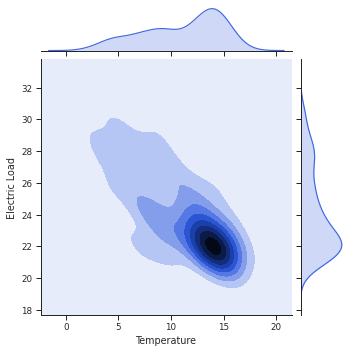

In [50]:
f=sns.jointplot(
    x='Temperature',
    y='Electric Load',
    data=avg_train_data_resampled[avg_train_data_resampled['Electric Load']<=resampled_max*.7],
    kind="kde",
    height=5,
    color='royalblue'
)
file_path=os.path.join(tikz_path,'jointplot_temp_load.pgf')
f.savefig(file_path)

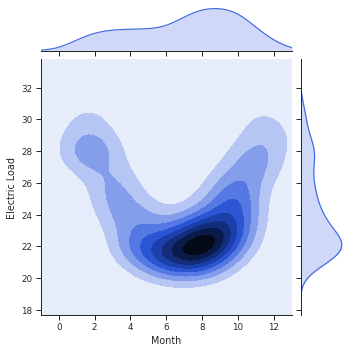

In [65]:
f=sns.jointplot(
    x=avg_train_data_resampled[avg_train_data_resampled['Electric Load'] <= resampled_max*.7].index.month,
    y=avg_train_data_resampled[avg_train_data_resampled['Electric Load'] <= resampled_max*.7]['Electric Load'],
    kind="kde",
    height=5,
    xlim=(-1,13),
    color='royalblue'
)
file_path=os.path.join(tikz_path,'jointplot_month_load.pgf')
f.savefig(file_path)

In [150]:
avg_train_data_resampled.corr()

,load,tempC
load,1.000000,-0.738633
tempC,-0.738633,1.000000


## Load Histogram

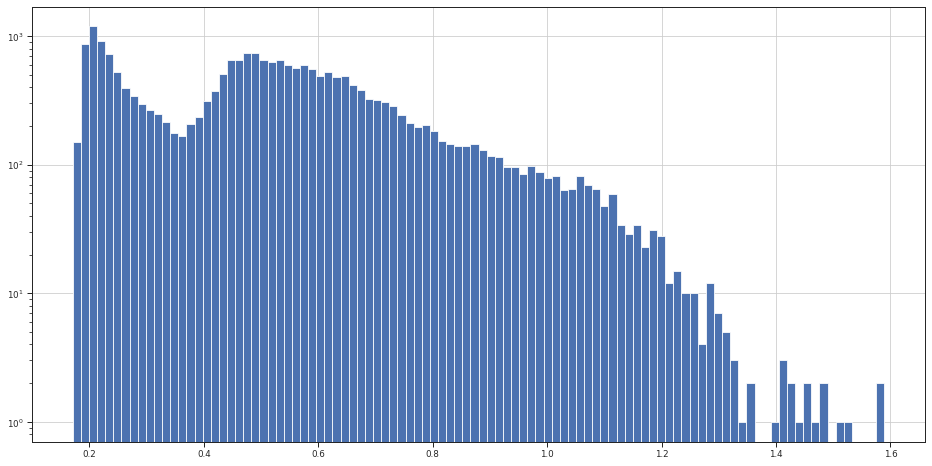

In [29]:
avg_train_data.load.hist(bins=100, figsize=(16,8), log=True)

In [120]:
clip=(-1e-5,maximum*.8)
kde_kws=dict(
    bw=.15,
    #clip=clip,
    gridsize=300
)

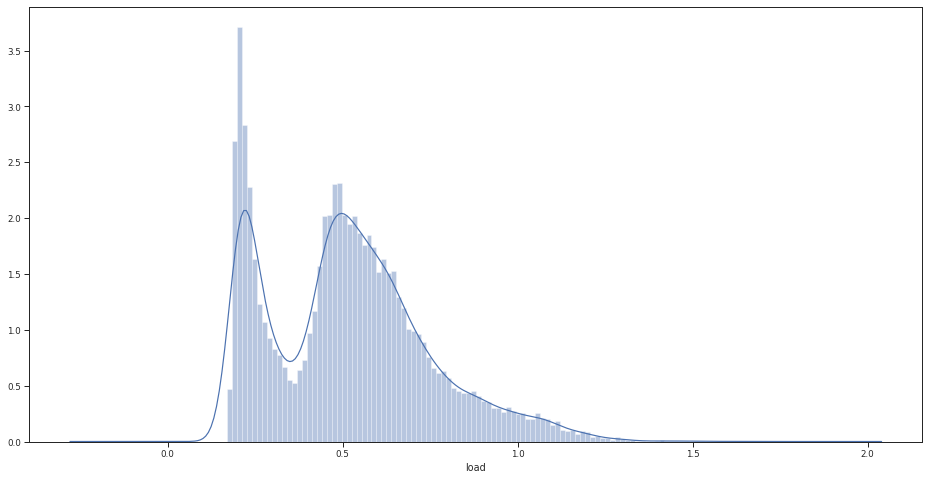

In [53]:
fig = plt.figure(figsize=(16,8))
ax=sns.distplot(avg_train_data.load,
                hist=True,
                kde=True,
                bins=100,
                #hist_kws={'range':clip},
                kde_kws=kde_kws)
#tikzplotlib.clean_figure()
file_path=os.path.join(tikz_path,'distplot.tex')
tikzplotlib.save(
    file_path,
    strict=False,
    add_axis_environment=False
    #axis_height=".8\\textheight",
    #axis_width=".8\\textwidth",
    #extra_axis_parameters=['forecast plot style']
)

## Density Estimation

In [ ]:
def perc25(x): return np.percentile(x, 25)
def perc50(x): return np.percentile(x, 50)
def perc75(x): return np.percentile(x, 75)
pt=selection.pivot_table(index='minute',
                  columns='is_holiday',
                  values='load',
                  aggfunc=[np.mean,np.std,perc25,perc50,perc75])
pt

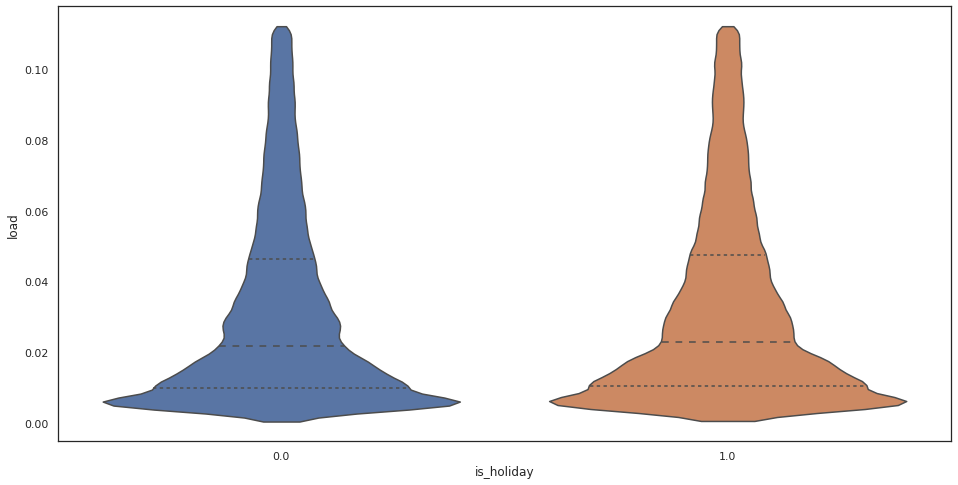

In [58]:
plt.figure(figsize=(16,8))

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(y="load",
               x="is_holiday",
               inner="quartile",
               scale='width',
               bw=0.05,
#               gridsize=len(selection)//10,
               cut=0,
               data=selection_filtered)
#sns.despine(left=True)

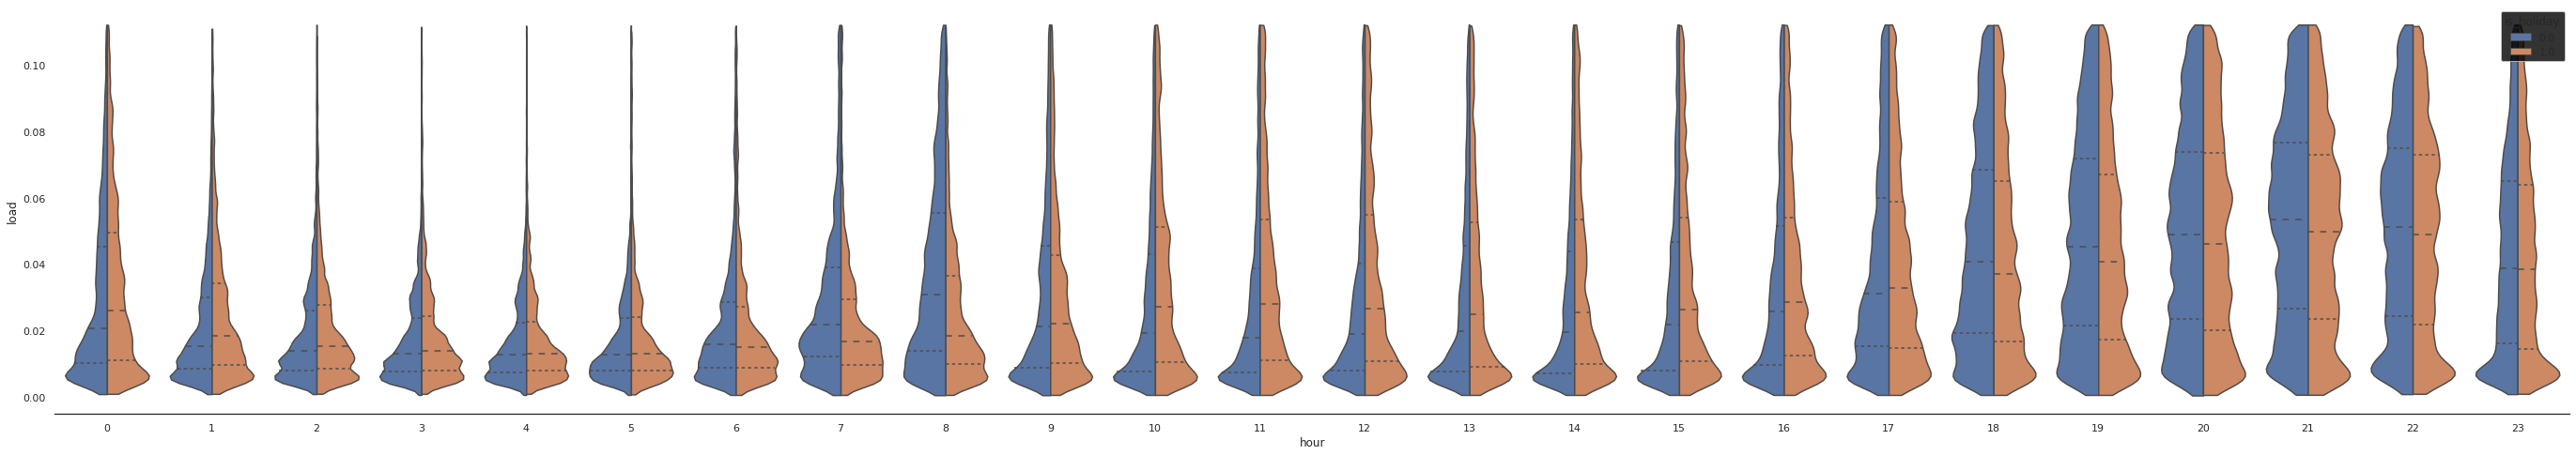

In [77]:
plt.figure(figsize=(48,8))

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(y="load",
               x="hour",
               hue='is_holiday',
               split=True,
               inner="quartile",
               scale='width',
               bw=0.08,
#               gridsize=len(selection)//10,
               cut=0,
               data=selection_filtered)
sns.despine(left=True)

In [33]:
from matplotlib.patches import ConnectionPatch

In [63]:
def stacked_dist_plot(
        data,
        hspace=-.85,
        clip=None
    ):
    resampled = 'hour' in data.columns
    if resampled:
        horizon_size = len(data.hour.unique())
    else:
        horizon_size = len(data.minute.unique())

    pal1 = sns.cubehelix_palette(horizon_size/2, rot=.55, light=.8, reverse=True).as_hex()
    pal2 = sns.cubehelix_palette(horizon_size/2, rot=.55, light=.8).as_hex()
    pal = pal1 + pal2

    fig , ax = plt.subplots(
        horizon_size,
        figsize=(16,horizon_size*0.8 if resampled else horizon_size*0.4),
        sharex=True, sharey=True)

    yaxis = ConnectionPatch(
        xyA=(0,0),
        xyB=(0,10),
        coordsA='data',
        coordsB='data',
        axesA=ax[-1],
        axesB=ax[0],
        color='black',
        lw=1.5,
        arrowstyle='->'
        #arrowstyle='Fancy, head_length=0.4, head_width=0.1, tail_width=0.3'
    )
    ax[0].add_artist(yaxis)
    kde_kwds=dict(
            legend=False,
            bw=.5,
            gridsize=200
    )
    if clip is not None:
        kde_kwds['clip'] = clip
    for i,h in enumerate(range(horizon_size)):
        
        sns.kdeplot(
            data[data.hour == h].load
            if resampled else
            data[data.minute == h].load,
            ax=ax[i],
            shade=True,
            alpha=0.8,
            color=pal[i],
            **kde_kwds
        )
        sns.kdeplot(
            data[data.hour == h].load
            if resampled else
            data[data.minute == h].load,
            ax=ax[i],
            alpha=1,
            color='w',
            lw=2,
            **kde_kwds
        )
        ax[i].set_facecolor((0,0,0,0))
        ax[i].set_frame_on(False)
        ax[i].set_title('')
        ax[i].axis('off')

        ax[i].text(0, 0.1, i, fontweight="bold", fontsize='xx-large', color=pal[i],
                   ha="left", va="center", transform=ax[i].transAxes)

    fig.subplots_adjust(hspace=hspace)

    return fig

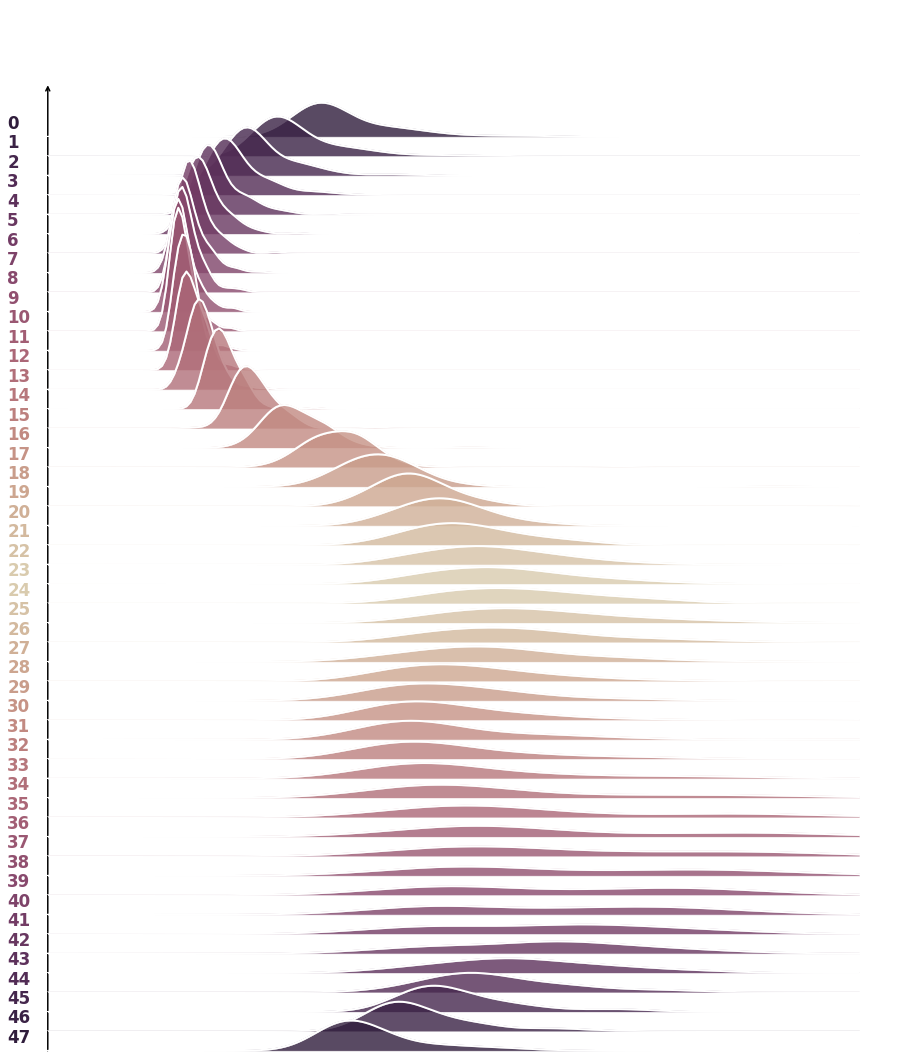

In [64]:
fig=stacked_dist_plot(avg_train_data[(avg_train_data.is_holiday==True)],clip=clip)
file_name='data_ridge_plot_weekend.pgf'
file_path=os.path.join(tikz_path,file_name)
fig.savefig(file_path, bbox_inches='tight', transparent=True)

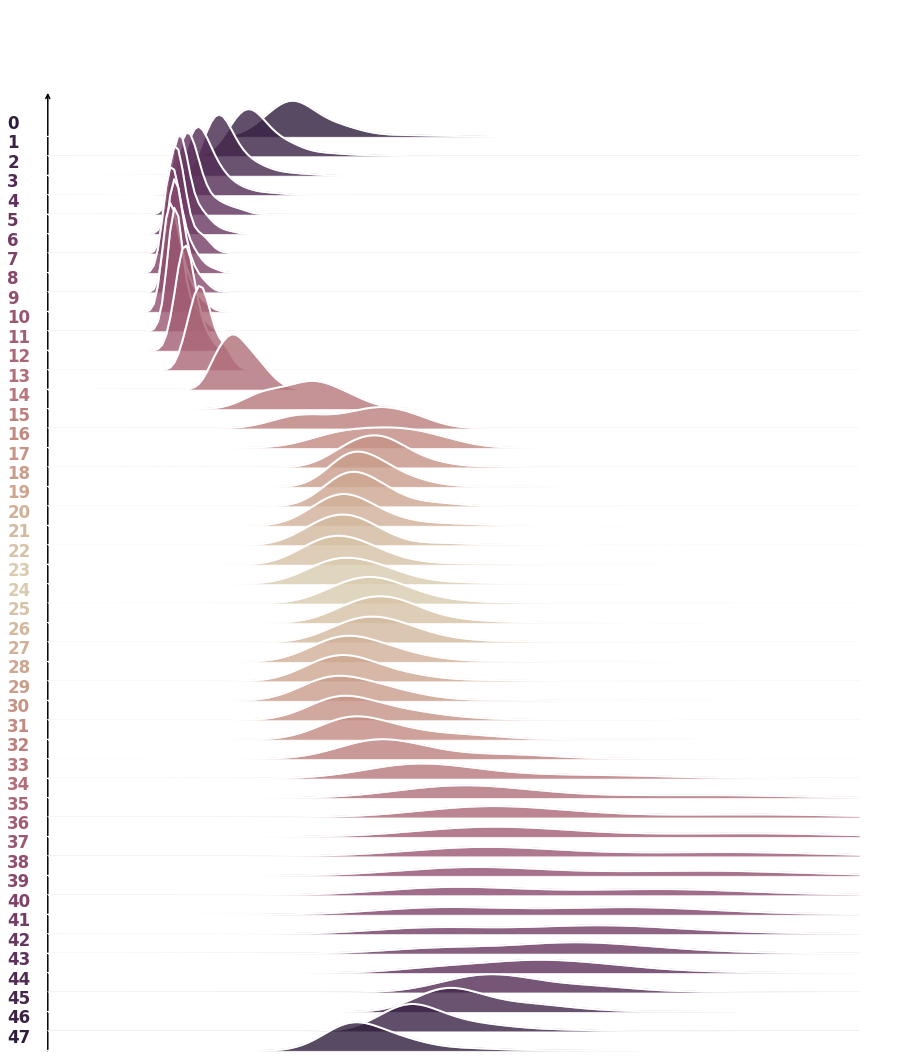

In [65]:
fig=stacked_dist_plot(avg_train_data[(avg_train_data.is_holiday==False)],clip=clip)
file_name='data_ridge_plot_weekday.pgf'
file_path=os.path.join(tikz_path,file_name)
fig.savefig(file_path, bbox_inches='tight', transparent=True)